# Feature Engineering - Credit Card Fraud Detection

## Objective
This notebook prepares the data for model training:
- Cleaning and transforming features  
- Handling missing or irrelevant data  
- Scaling and encoding  
- Managing class imbalance  
- Creating new useful variables  
- Splitting data for training and testing


In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit ,StratifiedKFold
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
import time

In [4]:
df = pd.read_csv("../data/raw/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
print("Any missing values:", df.isnull().values.any())
print("Number of duplicates:", df.duplicated().sum())


Any missing values: False
Number of duplicates: 1081


In [6]:
df = df.drop_duplicates()

In [7]:
df.shape

(283726, 31)

In [8]:
std_scaler = StandardScaler()
rob_scaler = RobustScaler()


df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1, 1))

df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1, 1))


# Drop the original 'Time' and 'Amount' columns
cols_to_drop = [c for c in ['Time', 'Amount'] if c in df.columns]
if cols_to_drop:
	df.drop(cols_to_drop, axis=1, inplace=True)

# Reorder so scaled_amount and scaled_time are the first two columns
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

# remove existing scaled cols then insert at front (safe even if they already were first)
df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.774718,-0.995290,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.268530,-0.995290,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.959811,-0.995279,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.411487,-0.995279,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.667362,-0.995267,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [9]:
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

X = df.drop('Class', axis=1)
y = df['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
Train: [ 30191  30261  30275 ... 283723 283724 283725] Test: [    0     1     2 ... 56805 56806 56807]
Train: [     0      1      2 ... 283723 283724 283725] Test: [ 30191  30261  30275 ... 113535 113536 113537]
Train: [     0      1      2 ... 283723 283724 283725] Test: [ 77084  77379  79220 ... 170292 170293 170294]
Train: [     0      1      2 ... 283723 283724 283725] Test: [149302 150027 150068 ... 226999 227000 227001]
Train: [     0      1      2 ... 226999 227000 227001] Test: [212341 212365 213905 ... 283723 283724 283725]


In [10]:
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values


train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)


print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

Label Distributions: 

[0.99833466 0.00166534]
[0.99832584 0.00167416]


Random Under-Sampling:
In this phase of the project we will implement "Random Under Sampling" which basically consists of removing data in order to have a more balanced dataset and thus avoiding our models to overfitting.

In [11]:
df = df.sample(frac=1)


fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:473]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
6882,-0.290641,-0.891780,-4.617217,1.695694,-3.114372,4.328199,-1.873257,-0.989908,-4.577265,0.472216,...,-0.039046,0.481830,0.146023,0.117039,-0.217565,-0.138776,-0.424453,-1.002041,0.890780,1
100623,7.329440,-0.201209,-0.758469,-0.045410,-0.168438,-1.313275,-1.901763,0.739433,3.071892,-0.483422,...,-0.032500,0.042619,0.397224,0.072229,-0.242276,0.560916,-0.540955,0.150606,-0.117140,1
186207,0.804478,0.497178,1.969692,-0.964303,-1.039434,-0.225736,-0.595363,-0.152755,-0.585377,-0.075564,...,-0.406164,0.062803,0.669876,0.012894,0.821999,0.010143,0.556735,-0.035228,-0.045596,0
45203,-0.292032,-0.498812,-2.524012,2.098152,-4.946075,6.456588,3.173921,-3.058806,-0.184710,-0.390420,...,-0.162797,0.027935,0.220366,0.976348,-0.290539,1.161002,0.663954,0.456023,-0.405682,1
150666,0.778751,0.107735,-10.850282,6.727466,-16.760583,8.425832,-10.252697,-4.192171,-14.077086,7.168288,...,-0.646818,2.541637,0.135535,-1.023967,0.406265,0.106593,-0.026232,-1.464630,-0.411682,1


In [10]:
new_df['Class'].value_counts()

Class
1    473
0    473
Name: count, dtype: int64

In [11]:
new_df.describe()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
count,946.000000,946.000000,946.000000,946.000000,946.000000,946.000000,946.000000,946.000000,946.000000,946.000000,...,946.000000,946.000000,946.000000,946.000000,946.000000,946.000000,946.000000,946.000000,946.000000,946.000000
mean,1.103982,0.028219,-2.216288,1.709977,-3.274123,2.232088,-1.479445,-0.688279,-2.597355,0.469479,...,0.194482,0.233336,0.052002,-0.059551,-0.054847,0.023721,0.031986,0.116042,0.044439,0.500000
std,3.037766,0.575267,5.326190,3.486199,6.054365,3.183789,4.093685,1.678792,5.528943,4.039991,...,1.001109,1.997916,0.975553,1.129943,0.564448,0.672147,0.474468,0.908222,0.431941,0.500264
min,-0.305938,-0.990519,-30.552380,-8.402154,-31.103685,-4.702261,-22.105532,-6.406267,-43.557242,-41.044261,...,-4.128186,-22.797604,-8.887017,-19.254328,-2.028024,-4.781606,-1.173105,-7.263482,-1.869290,0.000000
25%,-0.281046,-0.485426,-2.737732,-0.111408,-4.874396,-0.111878,-1.662966,-1.545391,-2.987794,-0.203164,...,-0.196906,-0.176224,-0.532045,-0.251602,-0.401120,-0.315098,-0.283748,-0.061174,-0.060365,0.000000
50%,-0.041302,-0.072379,-0.767505,0.890545,-1.239948,1.320419,-0.436359,-0.611726,-0.624162,0.163624,...,0.013743,0.134556,0.054847,-0.032304,0.003956,0.050324,-0.007702,0.046855,0.035121,0.500000
75%,1.084550,0.592382,1.022361,2.707052,0.413549,4.155427,0.476581,0.097005,0.267575,0.858397,...,0.408652,0.622056,0.588295,0.176262,0.375471,0.401076,0.329991,0.423476,0.216122,1.000000
max,29.256988,1.032555,2.382495,22.057729,3.014262,12.114672,11.095089,6.474115,5.802537,20.007208,...,11.059004,27.202839,8.361985,5.466230,1.167048,2.208209,2.745261,3.052358,4.927820,1.000000


Distribution of the Classes in the subsample dataset
Class
1    0.5
0    0.5
Name: count, dtype: float64


C:\Users\zineb\AppData\Local\Temp\ipykernel_6084\2127899503.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Class', data=new_df, palette=['#FF0000', "#1500FF"])


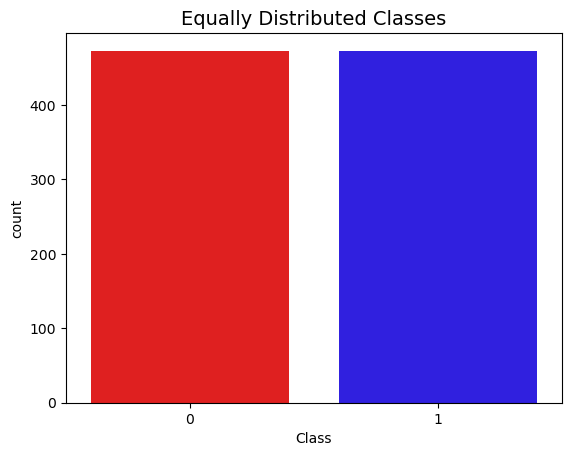

In [12]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['Class'].value_counts()/len(new_df))

# use keyword for x to avoid ambiguity in argument binding
sns.countplot(x='Class', data=new_df, palette=['#FF0000', "#1500FF"])
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

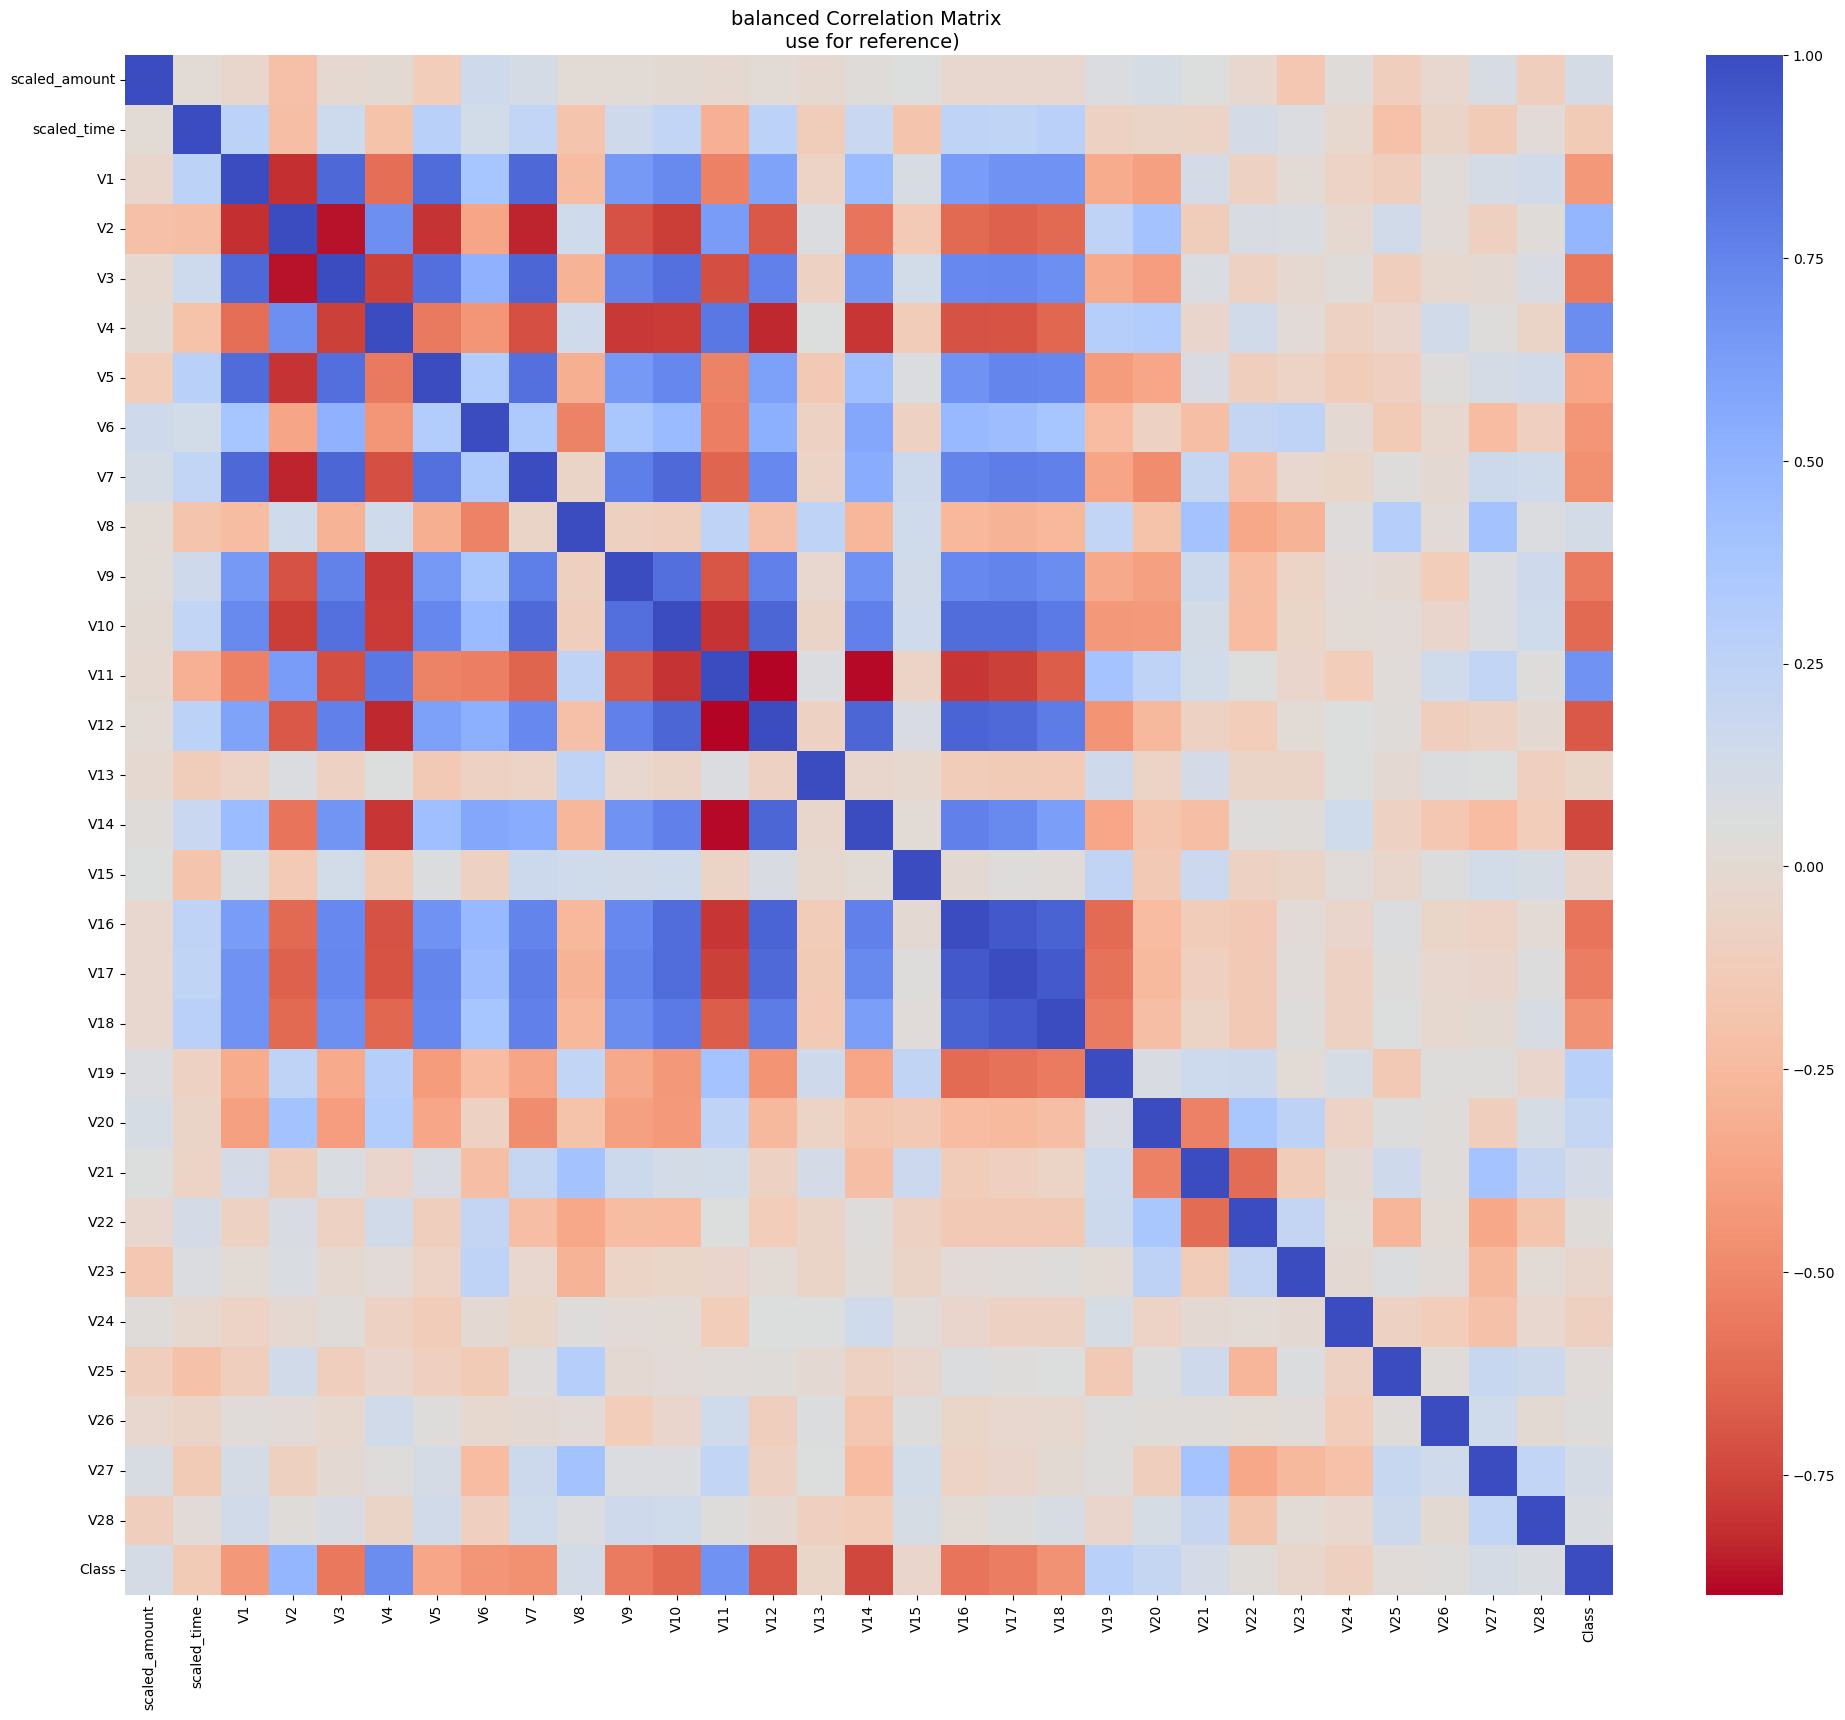

In [13]:
f, ax1 = plt.subplots(figsize=(24,20))

new_corr = new_df.corr()
sns.heatmap(new_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("balanced Correlation Matrix \n use for reference)", fontsize=14)

plt.show()

C:\Users\zineb\AppData\Local\Temp\ipykernel_6084\1939296060.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class", y="V17", data=new_df, palette=['#FF0000', "#1500FF"], ax=axes[0])
C:\Users\zineb\AppData\Local\Temp\ipykernel_6084\1939296060.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class", y="V14", data=new_df, palette=['#FF0000', "#1500FF"], ax=axes[1])
C:\Users\zineb\AppData\Local\Temp\ipykernel_6084\1939296060.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class", y="V12", data=new_df, palette=['#FF0000', "#1

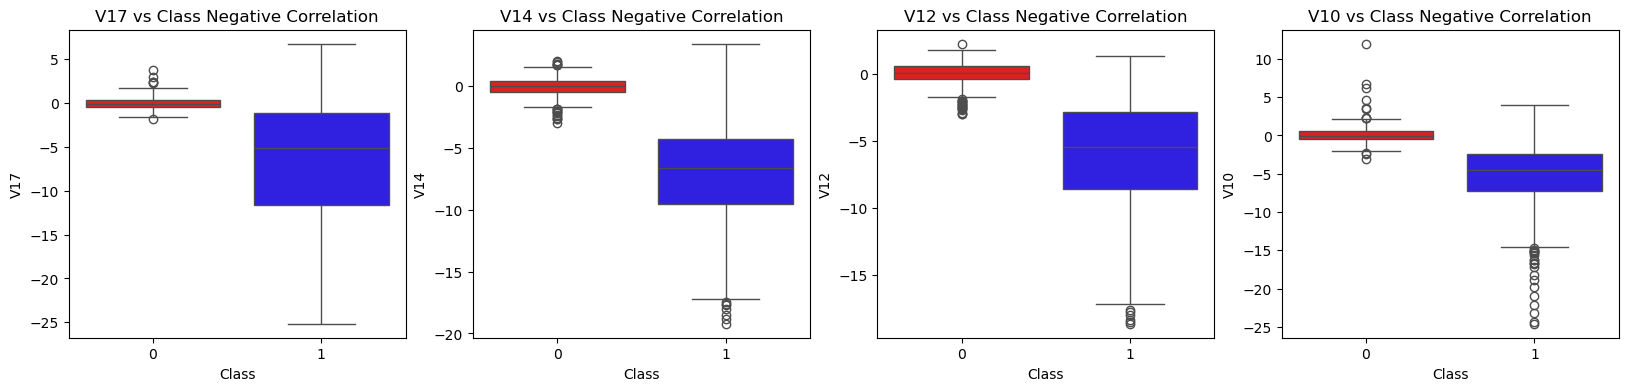

In [14]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))


sns.boxplot(x="Class", y="V17", data=new_df, palette=['#FF0000', "#1500FF"], ax=axes[0])
axes[0].set_title('V17 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=new_df, palette=['#FF0000', "#1500FF"], ax=axes[1])
axes[1].set_title('V14 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V12", data=new_df, palette=['#FF0000', "#1500FF"], ax=axes[2])
axes[2].set_title('V12 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V10", data=new_df, palette=['#FF0000', "#1500FF"], ax=axes[3])
axes[3].set_title('V10 vs Class Negative Correlation')

plt.show()

C:\Users\zineb\AppData\Local\Temp\ipykernel_6084\3104006606.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class", y="V11", data=new_df, palette=['#FF0000', "#1500FF"], ax=axes[0])
C:\Users\zineb\AppData\Local\Temp\ipykernel_6084\3104006606.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class", y="V4", data=new_df, palette=['#FF0000', "#1500FF"], ax=axes[1])
C:\Users\zineb\AppData\Local\Temp\ipykernel_6084\3104006606.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class", y="V2", data=new_df, palette=['#FF0000', "#150

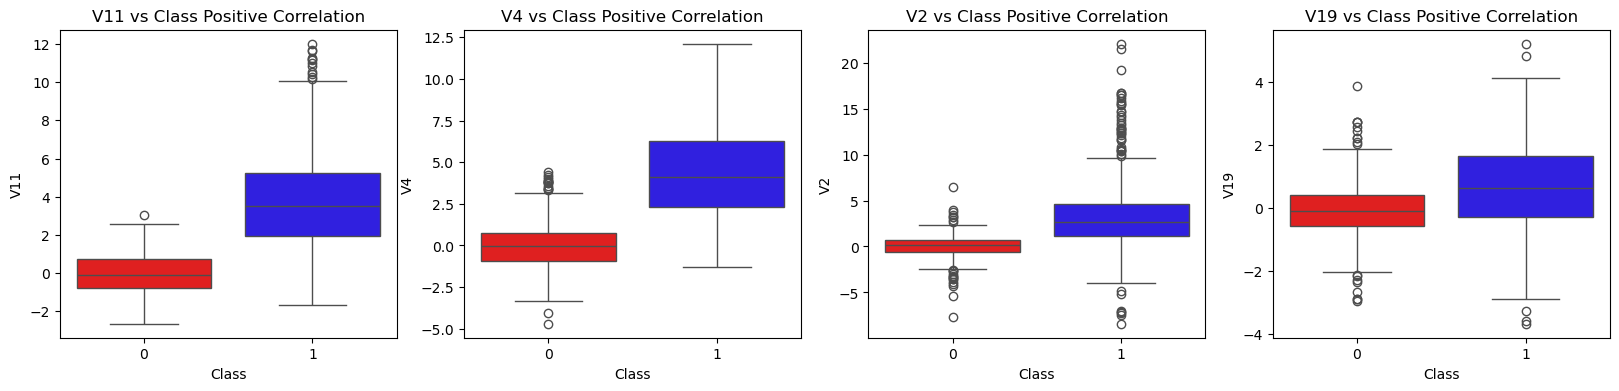

In [15]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))


sns.boxplot(x="Class", y="V11", data=new_df, palette=['#FF0000', "#1500FF"], ax=axes[0])
axes[0].set_title('V11 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V4", data=new_df, palette=['#FF0000', "#1500FF"], ax=axes[1])
axes[1].set_title('V4 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V2", data=new_df, palette=['#FF0000', "#1500FF"], ax=axes[2])
axes[2].set_title('V2 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V19", data=new_df, palette=['#FF0000', "#1500FF"], ax=axes[3])
axes[3].set_title('V19 vs Class Positive Correlation')

plt.show()

Negative Correlations: V17, V14, V12 and V10 are negatively correlated. Notice how the lower these values are, the more likely the end result will be a fraud transaction.
Positive Correlations: V2, V4, V11, and V19 are positively correlated. Notice how the higher these values are, the more likely the end result will be a fraud transaction.

C:\Users\zineb\AppData\Local\Temp\ipykernel_6084\3538466111.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(v14_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
C:\Users\zineb\AppData\Local\Temp\ipykernel_6084\3538466111.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(v12_fraud_dist,ax=ax2

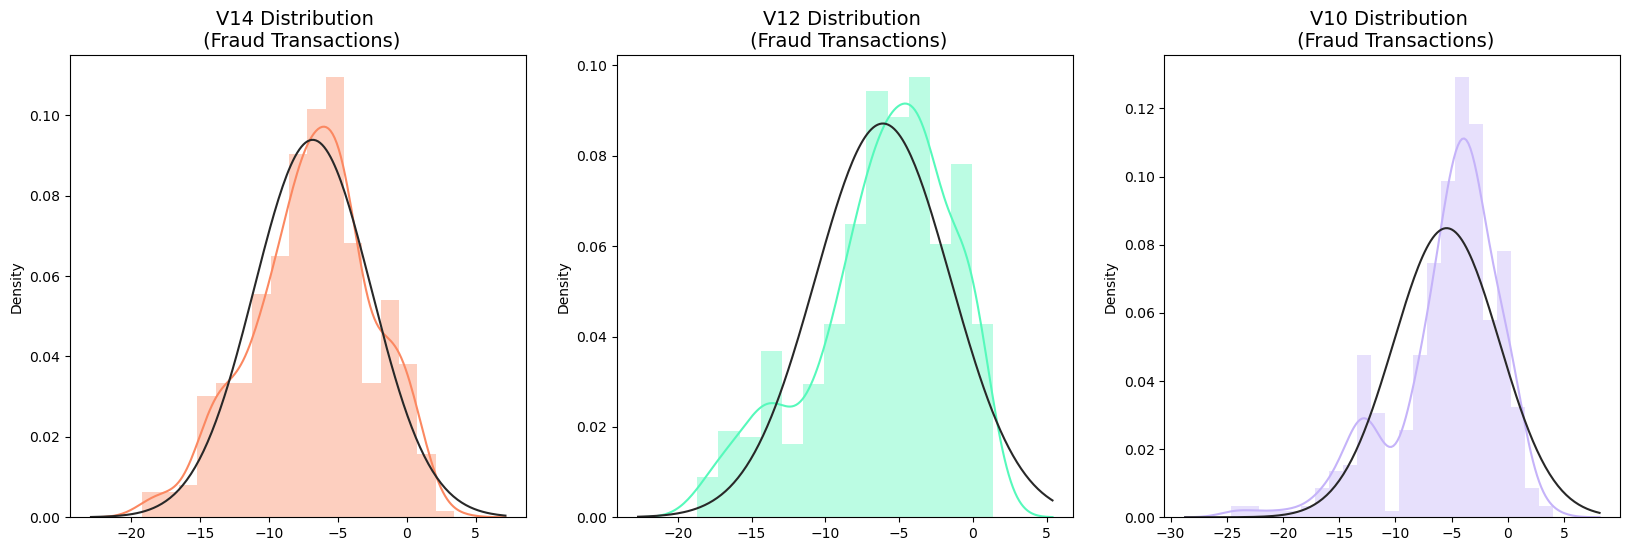

In [16]:
from scipy.stats import norm

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))

v14_fraud_dist = new_df['V14'].loc[new_df['Class'] == 1].values
sns.distplot(v14_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

v12_fraud_dist = new_df['V12'].loc[new_df['Class'] == 1].values
sns.distplot(v12_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)


v10_fraud_dist = new_df['V10'].loc[new_df['Class'] == 1].values
sns.distplot(v10_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('V10 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

In [17]:
# # -----> V14 Removing Outliers (Highest Negative Correlated with Labels)
v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('iqr: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut Off: {}'.format(v14_cut_off))
print('V14 Lower: {}'.format(v14_lower))
print('V14 Upper: {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V14 outliers:{}'.format(outliers))

new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)
print('----' * 44)

# -----> V12 removing outliers from fraud transactions
v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('V12 Lower: {}'.format(v12_lower))
print('V12 Upper: {}'.format(v12_upper))
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('V12 outliers: {}'.format(outliers))
print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))
print('----' * 44)


# Removing outliers V10 Feature
v10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25

v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('V10 Lower: {}'.format(v10_lower))
print('V10 Upper: {}'.format(v10_upper))
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('V10 outliers: {}'.format(outliers))
print('Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V10'] > v10_upper) | (new_df['V10'] < v10_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))

Quartile 25: -9.50514082568186 | Quartile 75: -4.25246559869278
iqr: 5.25267522698908
Cut Off: 7.87901284048362
V14 Lower: -17.38415366616548
V14 Upper: 3.62654724179084
Feature V14 Outliers for Fraud Cases: 7
V14 outliers:[-17.4759212828566, -17.6206343516773, -17.7216383537133, -18.0499976898594, -18.4937733551053, -19.2143254902614, -18.8220867423816]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V12 Lower: -16.971245282033493
V12 Upper: 5.672071569485119
V12 outliers: [-18.5536970096458, -18.0475965708216, -18.4311310279993, -17.1504052507291, -17.1829184301947, -17.003289445516, -18.6837146333443]
Feature V12 Outliers for Fraud Cases: 7
Number of Instances after outliers removal: 932
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------

C:\Users\zineb\AppData\Local\Temp\ipykernel_6084\3867450625.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class", y="V14", data=new_df,ax=ax1, palette=colors)
C:\Users\zineb\AppData\Local\Temp\ipykernel_6084\3867450625.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class", y="V12", data=new_df, ax=ax2, palette=colors)
C:\Users\zineb\AppData\Local\Temp\ipykernel_6084\3867450625.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class", y="V10", data=new_df, ax=ax3, palette=colors)


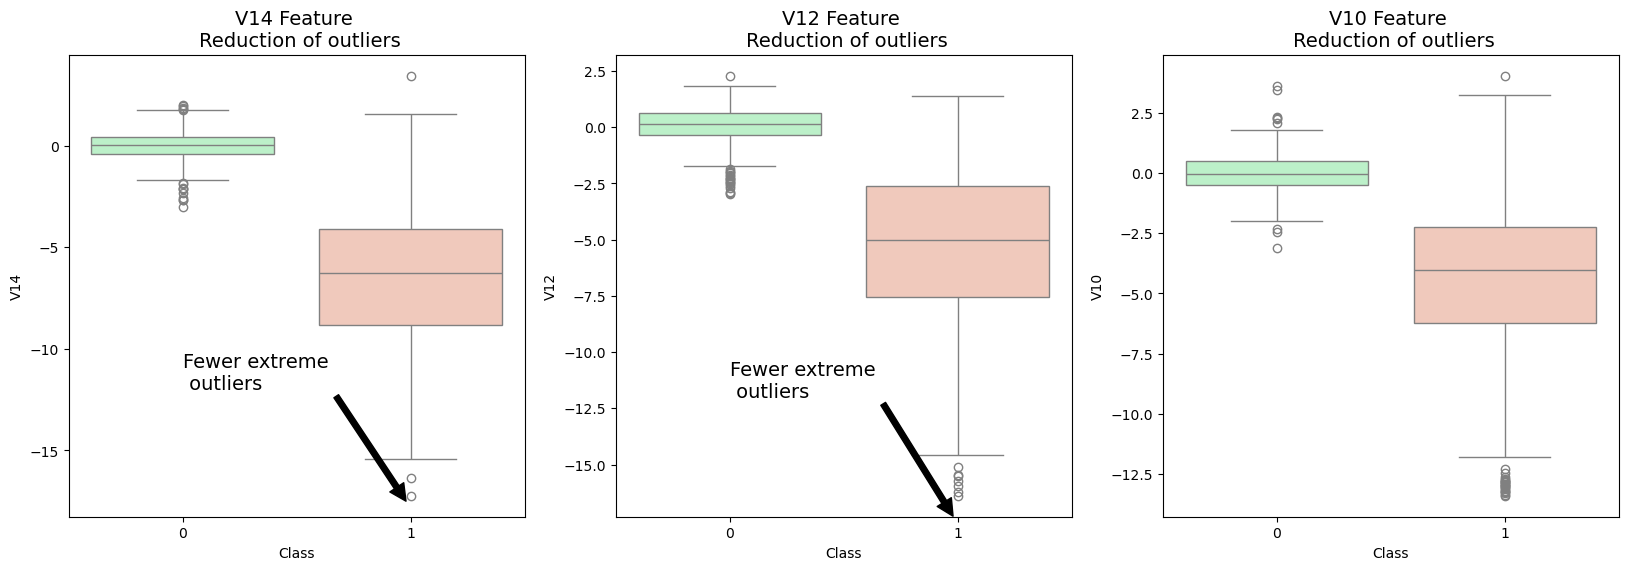

In [18]:
f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))

colors = ['#B3F9C5', '#f9c5b3']
# Boxplots with outliers removed
# Feature V14
sns.boxplot(x="Class", y="V14", data=new_df,ax=ax1, palette=colors)
ax1.set_title("V14 Feature \n Reduction of outliers", fontsize=14)
ax1.annotate('Fewer extreme \n outliers', xy=(0.98, -17.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature 12
sns.boxplot(x="Class", y="V12", data=new_df, ax=ax2, palette=colors)
ax2.set_title("V12 Feature \n Reduction of outliers", fontsize=14)
ax2.annotate('Fewer extreme \n outliers', xy=(0.98, -17.3), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature V10
sns.boxplot(x="Class", y="V10", data=new_df, ax=ax3, palette=colors)
ax3.set_title("V10 Feature \n Reduction of outliers", fontsize=14)
ax3.annotate('Fewer extreme \n outliers', xy=(0.95, -16.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)


plt.show()

Dimensionality Reduction and Clustering:

In [19]:
X = new_df.drop('Class', axis=1)
y = new_df['Class']


# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

T-SNE took 1.2e+01 s
PCA took 0.018 s
Truncated SVD took 0.012 s


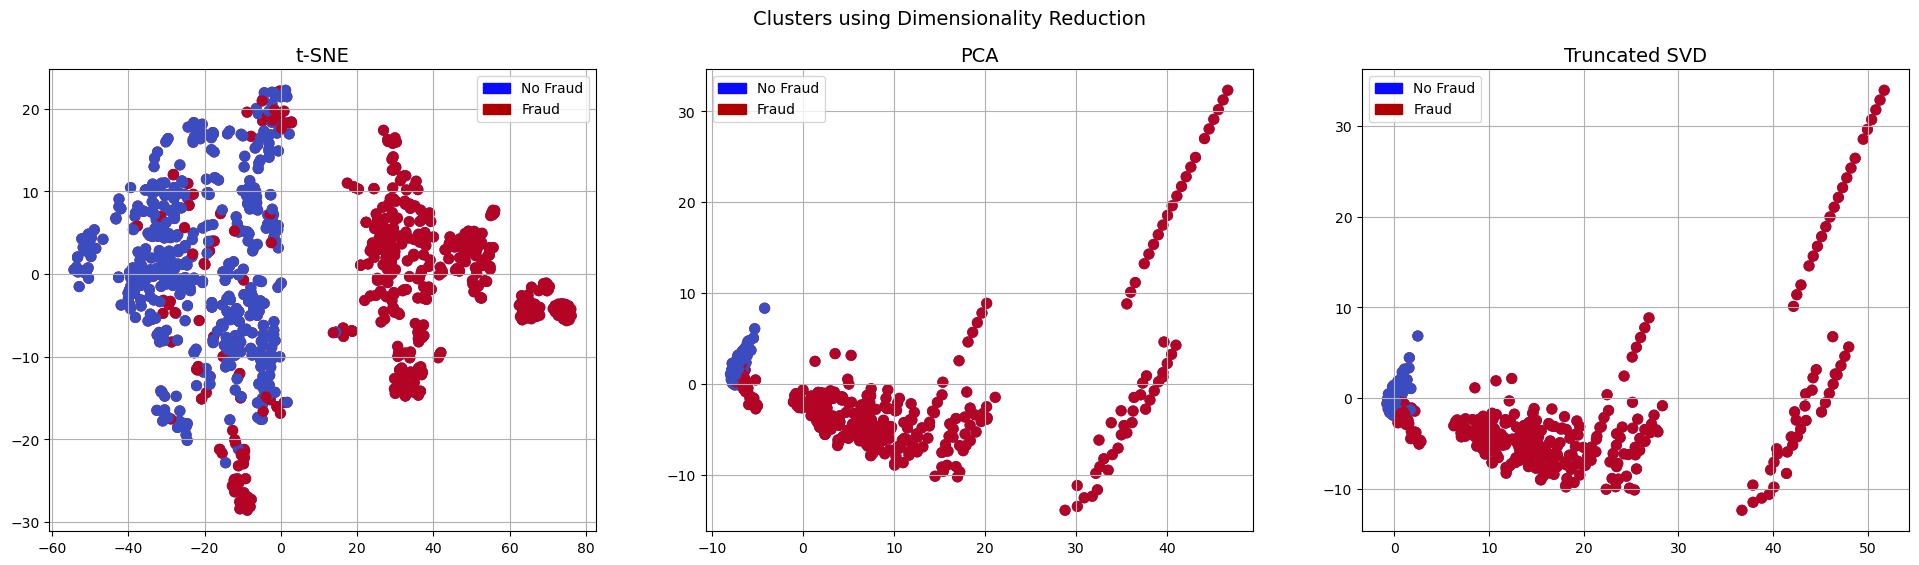

In [20]:
import matplotlib.patches as mpatches

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()

Summary:


t-SNE algorithm can pretty accurately cluster the cases that were fraud and non-fraud in our dataset.
Although the subsample is pretty small, the t-SNE algorithm is able to detect clusters pretty accurately in every scenario (I shuffle the dataset before running t-SNE)
This gives us an indication that further predictive models will perform pretty well in separating fraud cases from non-fraud cases.

In [21]:
X = new_df.drop('Class', axis=1)
y = new_df['Class']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [23]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [24]:
new_df.to_csv("../data/processed/creditcard_undersampled.csv", index=False)


SMOTE Technique (Over-Sampling)

In [12]:
from imblearn.over_sampling import SMOTE

In [13]:
df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
144472,0.111111,0.017128,-1.412413,1.165999,-0.927235,-1.640616,1.916794,3.125652,-0.418277,1.707750,...,-0.106026,0.013723,-0.361901,-0.079262,1.017664,0.000436,0.226896,-0.048396,0.010286,0
166383,-0.180921,0.391952,2.026915,-0.240298,-1.216793,0.245731,-0.070275,-0.739053,-0.016646,-0.084639,...,-0.283801,-0.271354,-0.771323,0.299811,-0.376422,-0.338907,0.202519,-0.086072,-0.075304,0
131742,1.382283,-0.058436,1.109810,-0.140926,-0.338281,0.897381,0.145526,-0.082495,0.197632,-0.098832,...,0.090731,0.040584,-0.126343,-0.377954,-1.015713,0.796306,-0.219787,-0.009682,0.026411,0
10484,-0.253233,-0.793312,1.088375,0.898474,0.394684,3.170258,0.175739,-0.221981,-0.022989,-0.010874,...,-0.217358,-0.423554,-0.800852,0.077614,0.167608,0.350182,-0.118941,0.012948,0.054254,1
164251,1.432346,0.374736,2.016057,-1.928422,-0.456868,-1.570739,-1.718484,-0.083764,-1.500271,0.082352,...,-0.223411,-0.230174,-0.468504,0.286058,-0.534640,-0.646121,-0.412961,0.020465,-0.029758,0


In [14]:
X_smote = df.drop('Class', axis=1)
y_smote = df['Class']

X_train_smote, X_test, y_train_smote, y_test = train_test_split(
    X_smote, y_smote, test_size=0.2, random_state=42, stratify=y_smote
)


In [15]:
X_test_original= pd.DataFrame(original_Xtest)
y_test_original= pd.DataFrame(original_ytest)
X_train_original= pd.DataFrame(original_Xtrain)
y_train_original= pd.DataFrame(original_ytrain)

X_test_original.to_csv("../data/processed/x_test_original.csv", index=False)
y_test_original.to_csv("../data/processed/y_test_original.csv", index=False)
X_train_original.to_csv("../data/processed/x_train_original.csv", index=False)
y_train_original.to_csv("../data/processed/y_train_original.csv", index=False)

In [16]:
smote = SMOTE(random_state=42, sampling_strategy=1.0)  
X_train_res, y_train_res = smote.fit_resample(X_train_smote, y_train_smote)


In [17]:
print("Before SMOTE:", y_train_smote.value_counts())
print("After SMOTE:", y_train_res.value_counts())


Before SMOTE: Class
0    226602
1       378
Name: count, dtype: int64
After SMOTE: Class
0    226602
1    226602
Name: count, dtype: int64


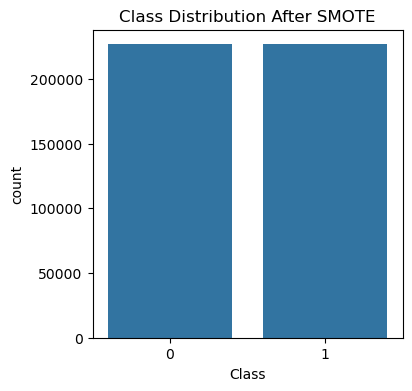

In [18]:
plt.figure(figsize=(4,4))
sns.countplot(x=y_train_res)
plt.title("Class Distribution After SMOTE")
plt.show()

In [19]:
X_train_res['Class'] = y_train_res
X_train_res.to_csv("../data/processed/creditcard_oversampled.csv", index=False)
